# Viterbi

Alice and Bob are working together to bake some treats while they are home for winter break.
Alice is in charge of sending Bob the recipe, and Bob is responsible for following directions.
Bob is *extremely* literal- if an error in the recipe says to use 2000 eggs instead of 2, he will use 2000 eggs without a second thought.
Alice is aware of Bob's lack of common sense, but she is also busy.
She already has the recipe open on her phone, so she wants to send it via email (using wifi) to Bob.
Unfortunately, Alice's evil next-door-neighboor Eve has her microwave running continuously at maximum power.
Microwaves emit a lot of radiation around wifi's 2.4GHz channels, causing interference.
This lab will explore different techniques for ensuring that Alice's message will make it to Bob uncorrupted.

## Preliminaries

We assume that Alice's message is $N$ bits long with each bit iid Bernoulli(0.5).
We model the channel as a [binary symmetric channel](http://en.wikipedia.org/wiki/Binary_symmetric_channel), as shown below.
Each bit sent through the channel is flipped (independently) with probability p.
We'll assume p=0.05, which is a fairly typical value for wireless communications.

![Alt](http://upload.wikimedia.org/wikipedia/commons/8/8e/Binary_symmetric_channel_%28en%29.svg)

We assume that Alice and Bob use some sort of message integrity check in their message (like a [CRC](http://en.wikipedia.org/wiki/Cyclic_redundancy_check)) - to keep things simple, let's assume Bob can detect any error with probability 1.

We also assume that Bob sends Alice an ACK or NACK and assume that this message always succeeds.
If Bob sends an ACK, Alice knows Bob got the message.
If Bob sends a NACK, Alice tries to send again.

## Repetition Code
We need a way to correct errors introduced by our noisy channel.
One of the simplest error correcting codes is the [repetition code](http://en.wikipedia.org/wiki/Repetition_code).

Repetition coding works by having Alice send each bit of her message $r$ times. Assuming each a 0 or 1 is equally likely and the crossover probability is less than 0.5, the optimal decoder is to use majority logic - i.e. for $r=3$ if Bob gets two 1s and one 0, he will decide 1. Ties are broken uniformly at random.

## Q1 Repetition Coding
### (A)
Denoting the crossover probability as $p <0.5$, write an explicit formula for the probability of a single bit error (denoted $P_b$) as a function of $r$. Be sure to take special care of the case when $r$ is even.

## <font color='blue'> Let $X$ be the bit Alice is sending, $Y_{i}$ be the $i$th received bit, $Y = \sum_{i=1}^{r}Y_{i}$, and $Z = \sum_{i=1}^{r}Z_{i}$ be the channel noise, per lecture notes 14/15.  Then $Y_{i} = (X + Z_{i}) mod 2$.  We note without $Z$, there is no noise or random-ness, so we really need only model $Z$.  $P(Z =0) = (1-p)$ and $P(Z=1)=p$.  Bruce is wrong when $Z>r/2$ and half the time when $Z=r/2$, no matter the value of $X$.  

\begin{align*}
P(Error) &= P(Z>r/2) + 1/2P(Z=r/2)\\
&= \sum_{k=r/2+\alpha}^{r} \binom{r}{k} p^{k}(1-p)^{r-k} + 1/2p^{r/2}(1-p)^{r/2}\\
\end{align*}
Where $\alpha = 1/2,r odd$, and $\alpha = 1, r even$, and the second term only applies when r is even.  

### (B)
For $p = 0.02$, $p = 0.05$ and $p =0.1$ plot $P_b$ for $r \in \{1,2,3,\ldots,14,15\}$. Use the semilogy command when plotting your bit error rate (BER). Be sure to label your axes and include a legend.


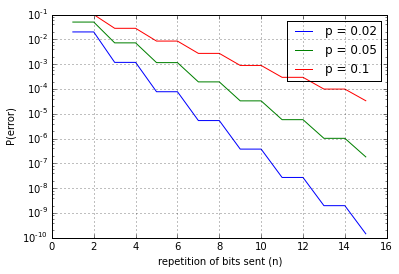

In [4]:
#%pylab
%matplotlib inline
from __future__ import division
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt

rmax = 15 #highest number of redundant bits
redundancy = np.arange(1, rmax+1)

pFail = [.02,.05,.1] #probability of channel flip
results = {} #dictionary to connect p in pFail to the Probability of failure given that p, in a vector indexed to r

#compute Pb for each p, input result vector into the pFail dictionary:

for p in pFail:
    Pb = np.zeros(rmax)
    for r in redundancy:
        if r % 2 != 0:  #odd
            Pb[r-1] = sum(binom.pmf(np.arange(r/2+.5,r+1),r,p))                
        else:           #even
            Pb[r-1] = sum(binom.pmf(np.arange(r/2+1,r+1),r,p)) + 0.5*binom.pmf(r/2,r,p)
    results[p] = Pb
    

plt.figure()
for i in range(3):
    plt.semilogy(redundancy, results[pFail[i]], label = "p = " + str(pFail[i])) 
plt.grid('on')
plt.legend()
plt.xlabel('repetition of bits sent (n)')
plt.ylabel('P(error)')
plt.show()  


###(C)
Why in practice would you avoid using an even number of repetitions?

## <font color='blue'>We can see for a given \textit{even} number of $r$ repetitions, the probability of failure is more than that of $r-1$ repetitions.  This comes from the 50% probability of being wrong when an half the bits are transmitted in error. So the extra bit sent to make $r$ comes with the cost of transmitting another redundant bit, and an increased chance of error.

## Convolutional Coding
It should make intuitive sense that we can get to low probabilities of error if we increase the number of repetitions.
However, increasing the number of repetitions means we are lowering Alice's effective datarate.
Alice's phone also has limited battery life, and sending lots of copies of the same data consumes a lot of energy.
Is it possible to correct a lot of errors without having to send so many extra bits? 

Yes! The 802.11 standards for wifi use convolutional codes and LDPC codes to correct errors.
Convolutional codes can be efficiently decoded using the Viterbi algorithm, so they will be the focus of this lab.
<img src="http://imgur.com/BzlsY89.png" width="500px"></img>

The above picture is a block diagram for a simple convolutional encoder.
The input message is treated as a stream of bits 

$$d_0, d_1, d_2, d_3 \ldots$$

The input is shifted through a series of delays - at time k, the input is $d_k$, the first delay element (the "D" on the left) contains $d_{k-1}$, and the last delay elements (the "D" on the right) contains $d_{k-2}$.
In this example, each input bit produces two output bits - the first output computed by the top "adder" and the second output computed by the bottom "adder". We denote the output of the top adder as $u_k$ and the bottom adder as $v_k$. The equations for each are given by

\begin{align*}
u_k &= d_k + d_{k-2} &\mod 2\\
v_k &= d_k + d_{k-1} + d_{k-2} &\mod 2
\end{align*}

We further define $d_{-2}= d_{-1}=0$ for initalization of the algorithm. The two outputs are interleaved into one bitstream so the output is $(u_0, v_0, u_1, v_1, u_2, v_2, ...)$.

The first thing to note is that this is not actually all that different from repetition coding.
Like repetition coding, we are adding redundancy by generating multiple output bits per input bit.
However, unlike repetition coding, convolutional codes have *memory*.
Each output bit is a function of multiple input bits.
The idea is that if there is an error, you should be able to use the surrounding bit estimates to help you figure out what was actually sent.

The figure below shows the state transition diagram corresponding to the example encoder above.
Each transition is labelled $d_k/(u_k, v_k)$.
The two bits inside the circle correspond to the *state*. In order to compute the next output we must have $d_{k-2},d_{k-1}$ so we represent our state to as two numbers $d_{k-2}d_{k-1}$ (of which there are 4 different combinations). 

As an example, consider the state $10$ and the transition $1/00$. We first identify $d_{k-2} = 1$ and $d_{k-1}=0$ from the state. From the transition information we identify $d_k = 1$, $u_k = 0$, and $v_k = 0$ (note that $u_k$ and $v_k$ need not be given as they are entirely determined by the other three variables). The new state is then $d_{k-1}d_k = 10$ which is consistent with the diagram

Be sure to convince yourself that the encoder above is equivalent to the state transition diagram below.

<img src="http://imgur.com/W9fSfpn.png" width="300px"></img>

If we assume that the input bits are iid Bernoulli(0.5), this is a Markov chain with every state equally likely.
We can run the Viterbi algorithm on our output bits (even after going through a noisy channel) to recover a good estimate of the input bits.

We assume that we start state 0.



## Q2 The Convolutional Encoder
###(A)
Implement the encoder described by the block diagram above.

In [5]:
import numpy as np
import pdb

# Convolutional Encoder
# Precondition:  An array of ones and zeros (raw message)
# Postcondition: An output stream of u(k) and v(k), per the above encoder instructions
def encode(message):
    fullmessage = np.concatenate(([0,0],message))  #prepend zero data
    output = []
    
    for i in np.arange(2,len(fullmessage)):
        u = (fullmessage[i] + fullmessage[i-2]) % 2
        v = (fullmessage[i] + fullmessage[i-1] + fullmessage[i-2]) % 2
        output = np.concatenate((output, [u, v]))
                       
    return output

###(B)
Print your encoder's output on the following bit streams.

In [6]:
print encode([1,1,0,1,0])
print encode([0,1,0,1,0])

[ 1.  1.  1.  0.  1.  0.  0.  0.  0.  1.]
[ 0.  0.  1.  1.  0.  1.  0.  0.  0.  1.]


## Q3 State Estimation of a Hidden Markov Model
We start by defining the random variables associated with the problem. We let $X_0,X_1,X_2\ldots$ be the binary random variables which are input into the encoder. We further define the random variables $U_0,U_1,\ldots$ and $V_0,V_1,\ldots$ to the result of the upper and lower branch of the convolutional encoding of $X_0,X_1,\ldots$. Lastly, we let $Y_0^u,Y_1^u,\ldots$ be the output when $U_0,U_1,\ldots$ are passed through the binary symmetric channel. We define $Y_0^v,Y_1^v,\ldots$ analogously for the $V_i$'s

### (A)
Draw a block diagram illustrating the relationships between the above random variables

<img src="files/Lab3q3b_scale.jpeg">

### (B)
Show that if the $X_i$'s are i.i.d. and equally probable 0 or 1, then the MAP rule

$$\arg \max_{d_0,\ldots,d_n}\boldsymbol{P}(X_0=d_0,\ldots, X_n = d_n| Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n)$$

is equivalent to the Maximum Likelihood rule

$$\arg \max_{d_0,\ldots,d_n} \boldsymbol{P}(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n|X_0=d_0,\ldots, X_n = d_n)$$

## <font color='blue'>We start with the MAP rule, and first implement Baye's rule, as in lecture 17:
\begin{align*}
\arg \max_{d_0,\ldots,d_n}\boldsymbol{P}(X_0=d_0,\ldots, X_n = d_n| Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n)\\
= \arg \max_{d_0,\ldots,d_n}\boldsymbol{P}\frac{(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n|X_0=d_0,\ldots, X_n = d_n)\boldsymbol{P}(X_0=d_0,\ldots, X_n = d_n)}{\boldsymbol{P}(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n )}\\
\end{align*}
## <font color='blue'>As we are maximizing with respect to the inputs, we can let the denominator go to 1
\begin{align*}
= \arg \max_{d_0,\ldots,d_n}\boldsymbol{P}(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n|X_0=d_0,\ldots, X_n = d_n)\boldsymbol{P}(X_0=d_0,\ldots, X_n = d_n)\\
\end{align*}
## <font color='blue'>If each X is iid and unbiased $\in\{0,1\}$, 
\begin{align*}
\boldsymbol{P}(X_0=d_0,\ldots, X_n = d_n) = \boldsymbol{P}(X_0=d_0),\ldots, \boldsymbol{P}(X_n = d_n) = 0.5^{n}\\
\end{align*}
## <font color='blue'>Since there is nothing to maximize there, we can remove these from the function as well without disturbing its maximization solution, and we are left with the maximum likelihood rule. QED

### (C)
Show that if $Z_1$, $Z_2$ and $Z_3$ are random variables such that $Z_1$ and $Z_3$ are independent conditional on $Z_2$ and $Z_2$ is a function of $Z_1$ (i.e. $Z_2 = g(Z_1)$) then 

$$\boldsymbol{P}(Z_3 = a|Z_1 = b) = \boldsymbol{P}(Z_3 = a|Z_2 = g(b))$$

## <font color='blue'>From the definition of conditional independence:
\begin{align}
\boldsymbol{P}(Z_3 = a|Z_2 = g(b)) = \boldsymbol{P}(Z_3 = a|Z_2 = g(b) \cap Z_1 = b))\\
\end{align}
## <font color='blue'>Since $Z_2$ is a function of $Z_1$,
\begin{align*}
\boldsymbol{P}(Z_2 = g(b)|Z_1 = b) = 1 = \frac{\boldsymbol{P}(Z_2 = g(b) \cap Z_1 = b)}{\boldsymbol{P}(Z_1 = b)}\\
\boldsymbol{P}(Z_1 = b) = \boldsymbol{P}(Z_2 = g(b) \cap Z_1 = b)\\
(Z_1 = b) = (Z_2 = g(b) \cap Z_1 = b)
\end{align*}
## <font color='blue'> We substitute this into (1)
\begin{align}
\boldsymbol{P}(Z_3 = a|Z_2 = g(b)) = \boldsymbol{P}(Z_3 = a|Z_1 = b))\\
\end{align}
## <font color='blue'> QED

### (D)
Using part(C) or otherwise, show that the expression in part(B) is equivalent to 

$$\arg \max_{d_0,\ldots,d_n} \boldsymbol{P}(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n|U_0=u_0, V_0 =v_0\ldots, U_n = u_n, V_n=v_n)$$

where $(u_0,v_0,\ldots,u_n,v_n)$ is the output stream corresponding to the input stream.

*Hint: take $Z_1 = (X_0,X_1,\ldots, X_n$)*

## <font color='blue'>Per the hint, we let $Z_1 = (X_0,X_1,...,X_n)$, and $P(Z_1 = \alpha) = P(X_0 = d_0, X_1 = d_1, ..., X_n = d_n)$.  Since each $U_i, V_i$ are a function of a subset of $(X_0,...,X_n)$, they are a function of $(X_0,...,X_n)$.  Let P(U_0=u_0, V_0 =v_0\ldots, U_n = u_n, V_n=v_n) = P(Z_2 = \beta)$.  Then $P(Z_2=\beta) = P(Z_2 = g(\alpha)) = P(Z_1 = \alpha)$.  And so, 

\begin{align*}
&\arg \max_{d_0,\ldots,d_n} \boldsymbol{P}(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n|X_0=d_0,\ldots, X_n = d_n) \\
&= arg \max_{d_0,\ldots,d_n} \boldsymbol{P}(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n|Z_1 = \alpha)  \\
&= arg \max_{d_0,\ldots,d_n} \boldsymbol{P}(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n|Z_2 = \beta) \\
&= arg \max_{d_0,\ldots,d_n} \boldsymbol{P}(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n|U_0=u_0, V_0 =v_0\ldots, U_n = u_n, V_n=v_n)
\end{align*}

### (E) 
Convince yourself that the maximization in part (D) can be solved using the Viterbi algorithm on the Markov chain above with an appropriate metric associated with each transition in the chain (branch metric). Give an explicit expression for the branch metric.

## <font color='blue'>I choose the Hamming distance between the $Y_i^u, Y_i^v$ and that of the possible states $U_i, V_i$, $\in \{0,1,2\}$, which is simply the absolute value of the difference of the bits recieved and possible states of the system.

Motivated from: http://home.netcom.com/~chip.f/viterbi/algrthms2.html

## Q4 The Viterbi Algorithm
###(A)
In the space below, implement a viterbi decoder for our 4-state example code.

In [66]:
import numpy as np
from __future__ import division

def viterbi(bits_in):
    # States (x[n-2], x[n-1]) as well as convolutional code pairs (u,v) are stored in arrays /data as follows:
    # 0,0 = 0 
    # 0,1 = 1
    # 1,0 = 2
    # 1,1 = 3
    
    # converts two binarys to indices per the above ruleset:
    def convert(a,b):
        if a == 0 and b == 0:
            return 0
        elif a == 0 and b == 1:
            return 1
        elif a == 1 and b ==0:
            return 2
        else: return 3
    
    # returns the hamming value (transition metric) of data having been converted to the range (0..3)
    def getHam(x, y):
        if x == 0 and y == 0:   return 0
        elif x == 0 and y == 1: return 1
        elif x == 0 and y == 2: return 1
        elif x == 0 and y == 3: return 2
        elif x == 1 and y == 0: return 1
        elif x == 1 and y == 1: return 0
        elif x == 1 and y == 2: return 2
        elif x == 1 and y == 3: return 1
        elif x == 2 and y == 0: return 1
        elif x == 2 and y == 1: return 2
        elif x == 2 and y == 2: return 0
        elif x == 2 and y == 3: return 1
        elif x == 3 and y == 0: return 2
        elif x == 3 and y == 1: return 1
        elif x == 3 and y == 2: return 1
        elif x == 3 and y == 3: return 0
        
    # table of allowed state transitions (tells if row(State) can transition to column(State).  Value is None if 
    # not possible, else value is the index (convert(u,v)) of the code (u,v pair) that makes that transition
    allowedStateTrans = [[0,3,None,None],[None,None,1,2],[3,0,None, None],[None, None, 2, 1]]
    
    # data = database: a list of lists of dictionaries.  
    # time and state are referenced by data[time][state] 
    # Each dictionary has keys: past state, past Hamm Error, current Hamm error
    # state attributes are reference by data[time][state]['key']
    data = []

    #########
    #initialize for time 1
    ############
    data.append([]) # append a list to describe all states at time 1, each state is a dictionary
    pastState = 0
    # 1D vector, each column is end state, each element is transition code if an allowed transition, None if not
    possibleNewStates = allowedStateTrans[pastState] 
    for i in np.arange(4): # iterate over states 
        data[0].append({}) # each dictionary is attributes of a given state
        if possibleNewStates[i] != None: # if an allowed transition: 
            # this stores the hamming distance between the bits_in code and the possible new States            
            data[0][i]['pastState'] = 0
            data[0][i]['pastHammError'] = 0
            data[0][i]['currHammError'] = getHam(convert(bits_in[0],bits_in[1]), (possibleNewStates[i]))
    ###########################

    
    #########
    # comparePaths(new input data, previous state information)
    # comparePaths populates a new state information given new input uv pair.  It looks at all possible transitions
    # between the old state and new states, calculates the accumulated error of each transition, and chooses
    # lower error if mulitple paths arrive at a given state.
    # Precondition:  an input of received uv pair converted to (0..3)
    #                a  list of dictionaries for time t-1 lastData [{},{},{},{}]
    # Postcondition: a list of dictionaries for time t
    ########
    def comparePaths(received, lastStates):
        newStates = [{},{},{},{}] #a list of dictionaries, one for each state
        tempState = {}
        for i in np.arange(4): #iterate over old states
            if lastStates[i]: 
                # if the state in the last time step (lastData) was occupied, we need to propagate if forward.
                transitions = allowedStateTrans[i] #allowed transitions from state i to state j (None if not allowed)
                for j in np.arange(4): #iterate over new states
                    if transitions[j] != None: #if an allowed transition from state i to state j,
                        tempState['pastState'] = i
                        tempState['pastHammError'] = lastStates[i]['currHammError']
                        tempState['currHammError'] = getHam(received, transitions[j]) + tempState['pastHammError'] 
                        if not newStates[j]: #state is empty, populate with tempState
                            newStates[j] = tempState.copy()
                        else:  #state is occupied, compare cumulative error between state and temp state.  
                               #Smaller error wins, in tie, no change
                            a =    newStates[j]['currHammError'] 
                            b =       tempState['currHammError'] 
                            if a > b:
                                newStates[j] = tempState.copy()                   
        return newStates  
    
    ######
    # calculate for time > 1
    ######
    for j in np.arange(1,len(bits_in)//2):
        # j corresponds to time: j = t -1 
        # this correlates to bits 2*j (u) and 2*j + 1 (v)
        received = convert(bits_in[2*j],bits_in[2*j+1])
        data.append([])
        data[j] = comparePaths(received,data[j-1]) # temporarily holds state information until lowest accumulated error is decided upon.  Then

        
    # now we have the path lengths at each step, we start at the end of the algorithm and work backwards, choosing
    # the shortest path (smallest error) at each step
    finalError = np.zeros(4)
    for i in np.arange(4):
        finalError[i] = data[-1][i]['currHammError'] + data[-1][i]['pastHammError']
    path = [np.argmin(finalError)] #the index of the state with the smallest error in the final state
    path = [data[-1][path[0]]['pastState']] + path #prepend the past state of the smallest error final state to path
    
    #start one from final state, work backworks, prepending states as we go
    for i in np.arange(len(data)-2,0,-1): 
        stepBack = [data[i][path[0]]['pastState']]
        path =     stepBack + path
    
    #maps the (0..3) indexes of state to bits produced pairs of x(n-2), x(n-1) bits
    def de_convert(path):
        message = []
        for i in np.arange(len(path)):
            if path[i]%2 != 0:
                message = message + [1]
            else:
                message = message + [0]
        return message   
    
    message = de_convert(path)
    
    return message

###(B)
The following code block defines two functions, one which converts strings to their binary ASCII representations, and the other that converts from bits to ASCII. Use your implementation of the Viterbi Algorithm to decode the message in 'secret.txt' (which has been encoded using the convolutional code described in this lab)

In [ ]:
#thanks http://stackoverflow.com/questions/10237926/convert-string-to-list-of-bits-and-viceversa
def tobits(s):
    result = []
    for c in s:
        bits = bin(ord(c))[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])
    return result

def frombits(bits):
    chars = []
    for b in range(len(bits) // 8):
        byte = bits[b*8:(b+1)*8]
        chars.append(chr(int(''.join([str(bit) for bit in byte]), 2)))
    return ''.join(chars)

In [67]:
fin = open('secret.txt', 'r')
secret_bits = [int(i) for i in fin.read()[1:-1].split(',')]
fin.close()

print frombits(viterbi(secret_bits))

Nice work, you're almost with the last lab of the quarter!




## Q5.  Empirical Bit Error Rate of Convolutional Coding
### (A) 
So how does the convolutional code compare with simple repetition coding?
We are going to plot the bit error rate. 

$$ BER =\frac{\textrm{Number of incorrectly decoded bits}}{\textrm{Total number of bits}}$$ 

for some different channel parameters. For $0.01\le p \le 0.1$ on the x-axis, plot the bit error rate on a log scale on the y-axis. Run *100 trials* for randomly generated 512-bit long inputs at each channel parameter (this might take a little while to run). Note that we have given you the code to simulate the binary symmetric channel.


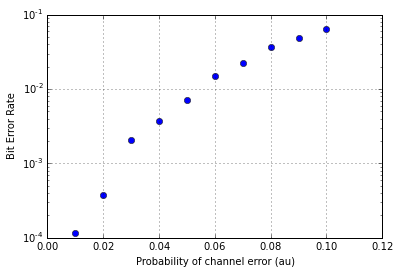

In [63]:
from matplotlib import pyplot as plt
%matplotlib inline
# Simulate the binary symmetric channel which corrupts the original bitstream with probability p
def bsc(bits_in, p=.05):
    out = []
    for b in bits_in:
        if np.random.uniform() > p:
            out.append(b)
        else:
            out.append(1-b)
    return np.array(out)       

# Plot against these values of the crossover probability p
ps = np.linspace(0.01, 0.1, 10)

# Find number of errors. requires sent and received to be same size binary lists.
def numErrors(sent, received):
    badBits = 0
    for i in np.arange(len(sent)):
        if sent[i] - received[i] != 0:
            badBits += 1
    return badBits

N = 100 #num trials
L = 512 #length of message

BER = np.zeros(shape = (len(ps),2)) #
    
for k in np.arange(len(ps)):  # iterate over each probability
    BER[k,0] = ps[k]
    for i in np.arange(N):
        msg        = np.ndarray.tolist(np.random.randint(2, size=(L)))  # create random message (as a list)
        codedMsg   = encode(msg)                                        # encode for channel transmission
        recMsg     = bsc(codedMsg, ps[k])                               # send coded message through channel
        decodedMsg = viterbi(recMsg)                                    # decode back into binary
        BER[k,1]  += numErrors(msg, decodedMsg)                         # count errors
    BER[k,1] /= (N*L)                                                   # normalize errors to get Bit Error Rate
    
plt.figure()
plt.semilogy(BER[:,0], BER[:,1], 'bo')
plt.grid('on')
plt.xlabel('Probability of channel error (au)')
plt.ylabel('Bit Error Rate')
plt.show()

In [57]:
BER

array([[  1.00000000e-02,   5.85937500e-05],
       [  2.00000000e-02,   4.88281250e-04],
       [  3.00000000e-02,   2.03125000e-03],
       [  4.00000000e-02,   3.49609375e-03],
       [  5.00000000e-02,   7.53906250e-03],
       [  6.00000000e-02,   1.33007812e-02],
       [  7.00000000e-02,   2.14257813e-02],
       [  8.00000000e-02,   3.42968750e-02],
       [  9.00000000e-02,   4.96679687e-02],
       [  1.00000000e-01,   6.35742187e-02]])

### (B)
Assume we are communicating over a binary symmetric channel with $p =0.05$. Using our repetition encoder, what is the smallest number of repetitions $r$ we would need in order to achieve a superior BER to our convolutional code? Suppose the coded symbols are sent over a 10MHz wireless channel at the rate of $10\times10^6$ symbols/sec. Compare the data rate, in bits per second (bps), of the convolutional code and the repetition code for this value of $r$. Now suppose, $p=0.02$. What is the minimum $r$ we need to outperform convolutional encoding? How does the data rate compare now?

## <font color='blue'>at $p=.05$ , the convolutional codec has a bit error rate of ~.0075.  The repetition code beats this BER when r = 3, where the BER is ~.00725.  The convolutional code takes two symbols to represent a bit $\frac{2 symbol}{bit}$ Given $10x10^6$ symbols per second, $bitRate_{convCode} = 5x10^6 bits/s$.  The repetition code with $r=3$ uses 3 symbols per bit, so $bitRate_{r=3} = 3.33x10^6 bits/s$, or 2/3 the speed of the convolutional code.  When $p=.02$, $BER_{conv} = .00048$, which would require $r=5$ repetitions.  $bitRate_{r=5} = 2x10^6 bits/s$ or 2/5 of the speed of the convolutional code.

<i>This lab is adapted from EE126 at UC Berkeley. Special thanks to Kangwook Lee, Rishi Sharma, Sahaana Suri, Ramtin Pedarsani, Kannan Ramchandran for developing the labs</i>